<a href="https://colab.research.google.com/github/VijayavaniBandi/RL_p1/blob/main/RL_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [102]:
!pip install gymnasium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
import time
import numpy as np
import gymnasium
from gymnasium import spaces
import os
import matplotlib.pyplot as plt
import pickle
import random
from PIL import Image
from google.colab import drive, widgets
from IPython.display import display, clear_output
import pandas as pd
import math

In [104]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [105]:
IMAGES_DIR = "/content/images"

In [106]:
MAX_TIMESTEP = 10
MAZE_WIDTH = 4
MAZE_LENGTH = 4
NUM_ACTIONS = 4
NUM_STATES = MAZE_WIDTH * MAZE_LENGTH

In [107]:
START_POS = np.asarray([3, 0])
FINISH_POS = np.asarray([0, 3])
GOLD_POS = np.asarray([0, 0])
SILVER_POS = np.asarray([3, 3])
OBSTACLE_POS = np.asarray([[2, 0], [1, 2], [1, 3], [3, 2]])

In [108]:
MAZE = np.zeros((MAZE_WIDTH, MAZE_LENGTH))
MAZE[tuple(START_POS)] = 2
MAZE[tuple(FINISH_POS)] = 3
MAZE[tuple(SILVER_POS)] = 4
MAZE[tuple(GOLD_POS)] = 5
for i in range(len(OBSTACLE_POS)):
    MAZE[tuple(OBSTACLE_POS[i])] = -1

In [109]:
IMAGE_DICT = {-1: 'obstacle.png', 0: 'path.png', 1: 'agent.png', 2: 'start.png',
              3: 'finish.png', 4: 'silver.png', 5: 'gold.png', 
              9: 'agent_obstacle.png', 12: 'agent_start.png', 
              13: 'agent_finish.png', 14: 'agent_silver.png', 
              15: 'agent_gold.png'}

In [110]:
def img_reshape(img):
    img = Image.open(os.path.join(IMAGES_DIR, img)).convert('RGB')
    img = img.resize((200, 200))
    img = np.asarray(img)
    return img


def maze_generator(maze):
    img_arr = []
    for state in maze:
        img_arr.append(img_reshape(f"{IMAGE_DICT[state]}"))
    array = np.array(img_arr)
    index, height, width, channels = array.shape
    img_grid = array.reshape(MAZE_WIDTH, MAZE_LENGTH, height, width, channels) \
                .swapaxes(1, 2).reshape(height * MAZE_WIDTH, 
                                        width * MAZE_LENGTH, channels)
    return img_grid

In [111]:
class MazeDeterministicEnv(gymnasium.Env):
    """
    Creating the following custom maze as environment.
    [5, 0, 0, 3,
    0, 0, -1, -1,
    -1, 0, 0, 0,
    2, 0, -1, 4]

    ### Description
    -> 0 represents a valid position for an agent
    -> -1 represents an obstacle
    -> 2 represents the start point
    -> 3 represents the finish point
    -> 4 represents silver
    -> 5 represents gold

    ### Action Space
    -> 0 represents moving up (North)
    -> 1 represents moving right (East)
    -> 2 represents moving down (South)
    -> 3 represents moving left (West)

    ### Reward
    -> 10 for reaching the finish line
    -> 4 for collecting gold
    -> 2 for collecting silver
    -> -5 for running into an obstacle
    -> -0.5 for any other step

    ### Motivation for the values
    -> The agent should be able to reach finish line, maximising the points it
      earns. With the given values, Collecting silver is not beneficial at all.
    """ 
    metadata = {"render_modes": ['human']}

    def __init__(self, env_type=None):
        self.observation_space = spaces.Discrete(NUM_STATES)
        self.action_space = spaces.Discrete(NUM_ACTIONS)

        self.maze = MAZE.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        self.agent_pos = START_POS.copy()

    def reset(self):
        self.agent_pos = START_POS.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        return self._get_state(self.agent_pos)

    def step(self, action):
        assert self.action_space.contains(action)

        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < 3:
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < 3:
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        self.maze = MAZE.copy()
        done = False
        if np.array_equal(self.agent_pos, FINISH_POS):
            reward = 10
            done = True
        elif any(np.array_equal(OBSTACLE_POS[i], self.agent_pos) for i in 
                 range(len(OBSTACLE_POS))):
            reward = -10
            done = True
        elif np.array_equal(self.agent_pos, SILVER_POS) and self.silver_qty > 0:
            reward = 2
            self.silver_qty = 0
        elif np.array_equal(self.agent_pos, GOLD_POS) and self.gold_qty > 0:
            reward = 4
            self.gold_qty = 0
        else:
            reward = -0.4

        info = {}
        return self._get_state(self.agent_pos), reward, done, info

    def _get_state(self, agent_pos):
        return agent_pos[0] * MAZE_LENGTH + agent_pos[1]

    def render(self):
        if self.gold_qty == 0:
            self.maze[tuple(GOLD_POS)] = 0
        if self.silver_qty == 0:
            self.maze[tuple(SILVER_POS)] = 0
        self.maze[tuple(self.agent_pos)] += 10
        if self.maze[tuple(self.agent_pos)] % 10 == 0:
            self.maze[tuple(self.agent_pos)] = 1
        fig = plt.figure(figsize=(8., 8.))
        plt.imshow(maze_generator(self.maze.ravel()))

In [112]:
class MazeStochasticEnv(gymnasium.Env):
    """
    Creating the following custom maze as environment.
    [5, 0, 0, 3,
    0, 0, -1, -1,
    -1, 0, 0, 0,
    2, 0, -1, 4]

    ### Description
    -> 0 represents a valid position for an agent
    -> -1 represents an obstacle
    -> 2 represents the start point
    -> 3 represents the finish point
    -> 4 represents silver
    -> 5 represents gold

    ### Action Space
    -> 0 represents moving up (North)
    -> 1 represents moving right (East)
    -> 2 represents moving down (South)
    -> 3 represents moving left (West)

    ### Reward
    -> 10 for reaching the finish line
    -> 4 for collecting gold
    -> 2 for collecting silver
    -> -5 for running into an obstacle
    -> -0.5 for any other step

    ### Motivation for the values
    -> The agent should be able to reach finish line, maximising the points it
      earns. With the given values, Collecting silver is not beneficial at all.
    """ 
    metadata = {"render_modes": ['human']}

    def __init__(self, env_type=None):
        self.observation_space = spaces.Discrete(NUM_STATES)
        self.action_space = spaces.Discrete(NUM_ACTIONS)

        self.maze = MAZE.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        self.agent_pos = START_POS.copy()

    def reset(self):
        self.agent_pos = START_POS.copy()
        self.gold_qty = 1
        self.silver_qty = 1
        return self._get_state(self.agent_pos)

    def step(self, action):
        assert self.action_space.contains(action)
        alternate_action = [act for act in range(self.action_space.n) 
                              if act != action]
        action = action if np.random.uniform() > 0.25 \
                          else np.random.choice(alternate_action)

        if action == 0 and self.agent_pos[0] > 0:
            self.agent_pos[0] -= 1
        elif action == 1 and self.agent_pos[1] < 3:
            self.agent_pos[1] += 1
        elif action == 2 and self.agent_pos[0] < 3:
            self.agent_pos[0] += 1
        elif action == 3 and self.agent_pos[1] > 0:
            self.agent_pos[1] -= 1

        self.maze = MAZE.copy()
        done = False
        if np.array_equal(self.agent_pos, FINISH_POS):
            reward = 10
            done = True
        elif any(np.array_equal(OBSTACLE_POS[i], self.agent_pos) for i in 
                 range(len(OBSTACLE_POS))):
            reward = -10
            done = True
        elif np.array_equal(self.agent_pos, SILVER_POS) and self.silver_qty > 0:
            reward = 2
            self.silver_qty = 0
        elif np.array_equal(self.agent_pos, GOLD_POS) and self.gold_qty > 0:
            reward = 4
            self.gold_qty = 0
        else:
            reward = -0.4

        info = {}
        return self._get_state(self.agent_pos), reward, done, info

    def _get_state(self, agent_pos):
        return agent_pos[0] * MAZE_LENGTH + agent_pos[1]

    def render(self):
        if self.gold_qty == 0:
            self.maze[tuple(GOLD_POS)] = 0
        if self.silver_qty == 0:
            self.maze[tuple(SILVER_POS)] = 0
        self.maze[tuple(self.agent_pos)] += 10
        if self.maze[tuple(self.agent_pos)] % 10 == 0:
            self.maze[tuple(self.agent_pos)] = 1
        fig = plt.figure(figsize=(8., 8.))
        plt.imshow(maze_generator(self.maze.ravel()))

In [113]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, pos):
    return np.random.choice(self.action_space.n)

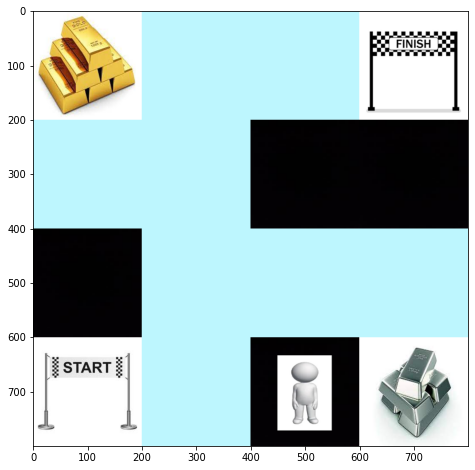

<IPython.core.display.Javascript object>

In [114]:
env = MazeDeterministicEnv()
agent = RandomAgent(env)

state = env.reset()

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
  clear_output(wait=True)

time.sleep(1)
done = False
while not done:
  action = agent.step(state)
  state, reward, done, info = env.step(action)
  with output_grid.output_to(0, 0):
    clear_output(wait=True)
    env.render()
  time.sleep(1)

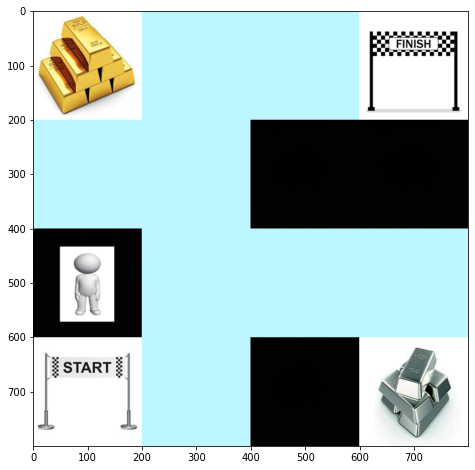

<IPython.core.display.Javascript object>

In [115]:
env = MazeStochasticEnv()
agent = RandomAgent(env)

state = env.reset()

output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  env.render()
  clear_output(wait=True)

time.sleep(1)
done = False
while not done:
  action = agent.step(state)
  state, reward, done, info = env.step(action)
  with output_grid.output_to(0, 0):
    clear_output(wait=True)
    env.render()
  time.sleep(1)

Plot code

In [116]:
def graph_decay_rewards(episodes, max_epsilon, min_epsilon, rewards):
  decay_rate = pow((min_epsilon/ max_epsilon), (1/ episodes))
  fig, ax = plt.subplots(2, 1, figsize=(15, 10))
  ax[0].plot(range(episodes), [decay_rate ** i for i in range(episodes)])
  ax[0].set_xlabel('Episode')
  ax[0].set_ylabel('Epsilon Decay')
  ax[1].plot(range(episodes), rewards)
  ax[1].set_xlabel('Episode')
  ax[1].set_ylabel('Total Reward')
  plt.show()

def graph_algo(episodes, q_rewards, sarsa_rewards):
  plt.plot(range(episodes), q_rewards, color='r', label='q_learning')
  plt.plot(range(episodes), sarsa_rewards, color='g', label='sarsa')
  plt.xlabel("Episodes")
  plt.ylabel("Total Rewards")
  plt.title("Q-learning vs SARSA")
  plt.legend()
  plt.show()

# def graph_metrics(metrics, title, x_label, y_label):
#   plt.plot(metrics)
#   plt.title(title)
#   plt.xlabel(x_label)
#   plt.ylabel(y_label)
#   plt.show()     

Hyperparameters

In [117]:
alpha = 0.1
gamma = 0.99
max_epsilon = 1
min_epsilon = 0.01
episodes = 1000
max_steps = 100

Instances of environments

In [118]:
d_env = MazeDeterministicEnv()
s_env = MazeStochasticEnv()

Q -learning

In [119]:
class QLearningAgent:
  def __init__(self, num_states, num_actions, alpha, gamma, max_epsilon, min_epsilon):
    self.num_states = num_states
    self.num_actions = num_actions
    self.alpha = alpha
    self.gamma = gamma
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.q_table = np.zeros((num_states, num_actions))
    self.rewards = []

  def save_model(self, filename): 
    pickle.dump(self.q_table, open(filename, 'wb'))

  def load_model(self, filepath): 
    with open(filepath, 'wb') as f:
      self.q_table= pickle.load(f)

  def train(self, env, episodes, max_steps):
    decay_rate = pow((self.min_epsilon/ self.max_epsilon), (1/ episodes))
    epsilon = self.max_epsilon
    for episode in range(episodes):
      state = env.reset()
      done = False
      total_reward = 0
      for step in range(max_steps):
      # Choose action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
          action = random.randint(0, self.num_actions-1)
        else:
          action = np.argmax(self.q_table[state, :])
        # Take the action and observe the next state and reward
        next_state, reward, done, info = env.step(action)

        # Update Q-value
        self.q_table[state, action] += self.alpha*(reward + self.gamma*np.max(self.q_table[next_state, :]) - self.q_table[state, action])
        state = next_state
        total_reward += reward
        if done:
          break
      self.rewards.append(total_reward)
      epsilon *= decay_rate
      # Print episode results
      if episode % 100 == 0:
        print("Episode: {}, Total Reward: {}, Epsilon: {:.2f}".format(episode, total_reward, epsilon))

Q-learning for Deterministic

Episode: 0, Total Reward: -12.0, Epsilon: 1.00
Episode: 100, Total Reward: -11.2, Epsilon: 0.63
Episode: 200, Total Reward: -10.4, Epsilon: 0.40
Episode: 300, Total Reward: 11.2, Epsilon: 0.25
Episode: 400, Total Reward: 11.6, Epsilon: 0.16
Episode: 500, Total Reward: 10.8, Epsilon: 0.10
Episode: 600, Total Reward: -10.4, Epsilon: 0.06
Episode: 700, Total Reward: 11.6, Epsilon: 0.04
Episode: 800, Total Reward: 11.6, Epsilon: 0.03
Episode: 900, Total Reward: 11.6, Epsilon: 0.02


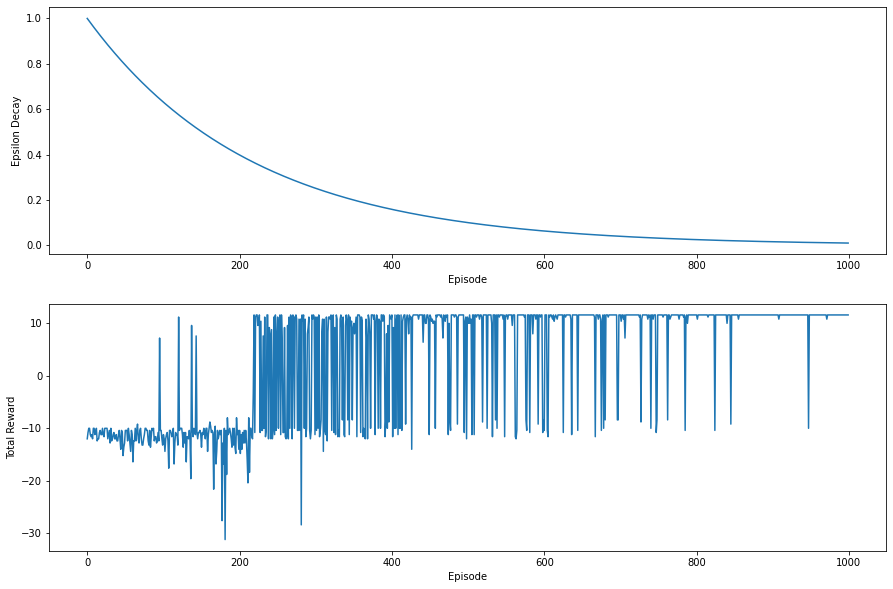

In [120]:
state=d_env.reset()
q_agent_d = QLearningAgent(d_env.observation_space.n, d_env.action_space.n, alpha, gamma, max_epsilon, min_epsilon)
q_agent_d.train(d_env, episodes, max_steps)
q_agent_d.save_model('q_learning_deterministic.pkl')
graph_decay_rewards(episodes, max_epsilon, min_epsilon, q_agent_d.rewards)


Q-learning for Stochastic

Episode: 0, Total Reward: -10, Epsilon: 1.00
Episode: 100, Total Reward: -11.6, Epsilon: 0.63
Episode: 200, Total Reward: -10.8, Epsilon: 0.40
Episode: 300, Total Reward: -12.0, Epsilon: 0.25
Episode: 400, Total Reward: -10.8, Epsilon: 0.16
Episode: 500, Total Reward: -10.8, Epsilon: 0.10
Episode: 600, Total Reward: -12.0, Epsilon: 0.06
Episode: 700, Total Reward: 7.2, Epsilon: 0.04
Episode: 800, Total Reward: -15.2, Epsilon: 0.03
Episode: 900, Total Reward: -10.8, Epsilon: 0.02


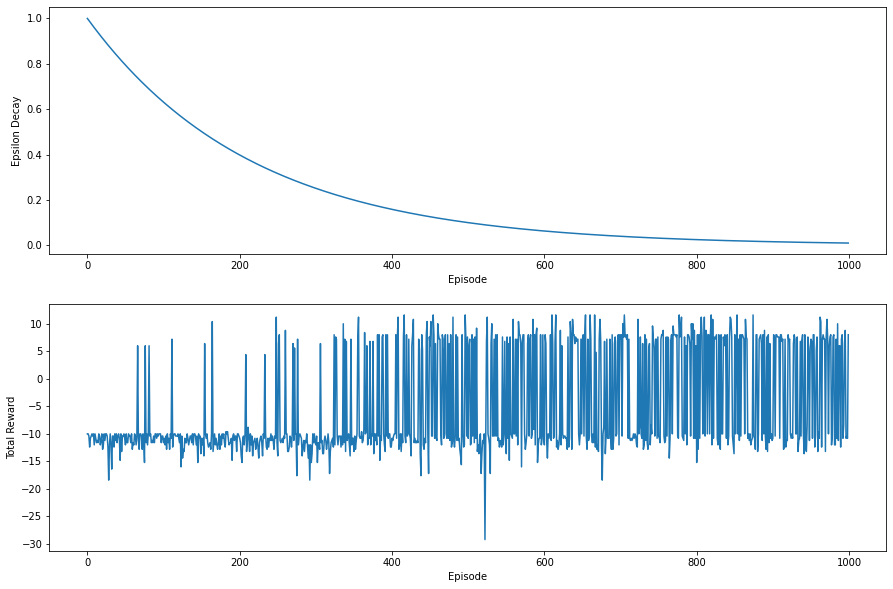

In [121]:
state=s_env.reset()
q_agent_s = QLearningAgent(s_env.observation_space.n, s_env.action_space.n, alpha, gamma, max_epsilon, min_epsilon)
q_agent_s.train(s_env, episodes, max_steps)
q_agent_s.save_model('q_learning_stochastic.pkl')
graph_decay_rewards(episodes, max_epsilon, min_epsilon, q_agent_s.rewards)

SARSA 

In [122]:
class SARSAAgent:
  def __init__(self, num_states, num_actions, alpha, gamma, max_epsilon, min_epsilon):
    self.num_states = num_states
    self.num_actions = num_actions
    self.alpha = alpha
    self.gamma = gamma
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.q_table = np.zeros((num_states, num_actions))
    self.rewards = []

  def save_model(self, filename): 
    pickle.dump(self.q_table, open(filename, 'wb'))

  def load_model(self, filepath): 
    with open(filepath, 'wb') as f:
      self.q_table= pickle.load(f)

  def train(self, env, episodes, max_steps):
    decay_rate = pow((self.min_epsilon/ self.max_epsilon), (1/ episodes))
    epsilon = self.max_epsilon
    for episode in range(episodes):
      state = env.reset()
      done = False
      total_reward = 0
      if random.uniform(0, 1) < epsilon:
        action = random.randint(0, self.num_actions-1)
      else:
        action = np.argmax(self.q_table[state, :])
      for step in range(max_steps):
        next_state, reward, done, info = env.step(action)
        if random.uniform(0, 1) < epsilon:
          next_action = random.randint(0, self.num_actions-1)
        else:
          next_action = np.argmax(self.q_table[state, :])
        # Update Q-value
        self.q_table[state, action] += self.alpha*(reward + self.gamma*self.q_table[next_state, next_action] - self.q_table[state, action])
        state = next_state
        action = next_action
        total_reward += reward
        if done:
          break
      self.rewards.append(total_reward)
      epsilon *= decay_rate
      # Print episode results
      if episode % 100 == 0:
        print("Episode: {}, Total Reward: {}, Epsilon: {:.2f}".format(episode, total_reward, epsilon))

SARSA for Determenistic

Episode: 0, Total Reward: -10.8, Epsilon: 1.00
Episode: 100, Total Reward: -12.4, Epsilon: 0.63
Episode: 200, Total Reward: -10.8, Epsilon: 0.40
Episode: 300, Total Reward: -10.4, Epsilon: 0.25
Episode: 400, Total Reward: -10.4, Epsilon: 0.16
Episode: 500, Total Reward: -10, Epsilon: 0.10
Episode: 600, Total Reward: -10, Epsilon: 0.06
Episode: 700, Total Reward: -10, Epsilon: 0.04
Episode: 800, Total Reward: -10, Epsilon: 0.03
Episode: 900, Total Reward: -10, Epsilon: 0.02


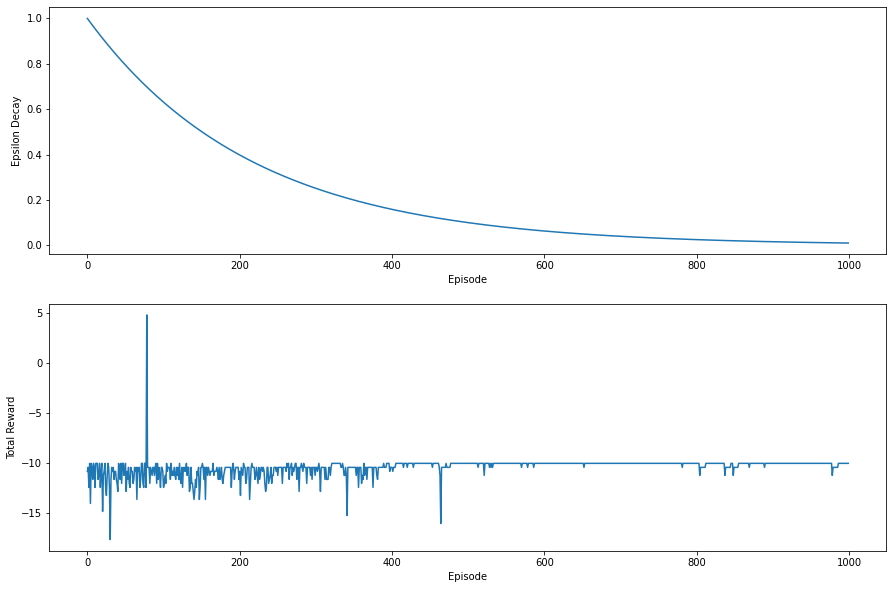

In [123]:
state=d_env.reset()
sarsa_agent_d = SARSAAgent(d_env.observation_space.n, d_env.action_space.n, alpha, gamma, max_epsilon, min_epsilon)
sarsa_agent_d.train(d_env, episodes, max_steps)
sarsa_agent_d.save_model('sarsa_deterministic.pkl')
graph_decay_rewards(episodes, max_epsilon, min_epsilon, sarsa_agent_d.rewards)

SARSA for Stochastic

Episode: 0, Total Reward: -10, Epsilon: 1.00
Episode: 100, Total Reward: -10.4, Epsilon: 0.63
Episode: 200, Total Reward: -10.4, Epsilon: 0.40
Episode: 300, Total Reward: -10.4, Epsilon: 0.25
Episode: 400, Total Reward: -11.2, Epsilon: 0.16
Episode: 500, Total Reward: -12.0, Epsilon: 0.10
Episode: 600, Total Reward: -10.4, Epsilon: 0.06
Episode: 700, Total Reward: -10, Epsilon: 0.04
Episode: 800, Total Reward: -10.4, Epsilon: 0.03
Episode: 900, Total Reward: -10.4, Epsilon: 0.02


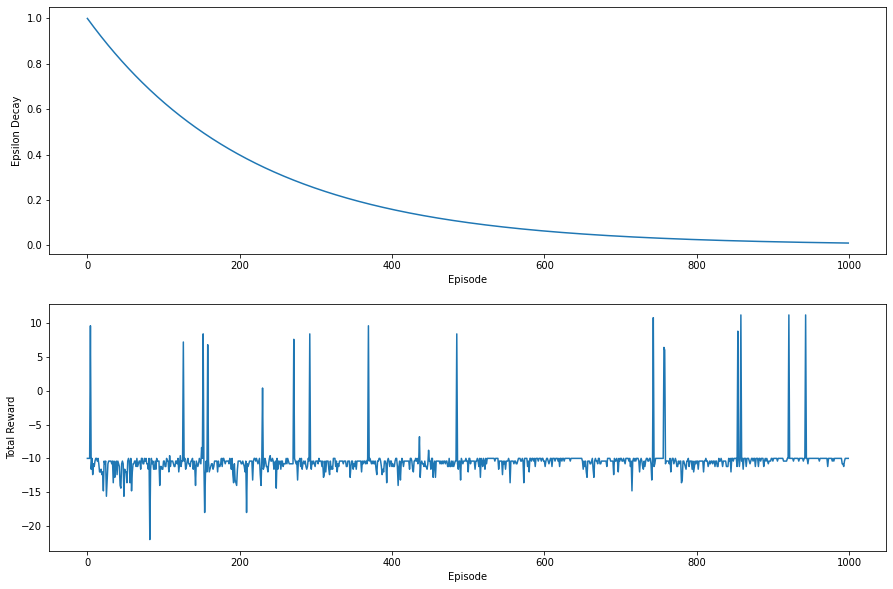

In [124]:
state=s_env.reset()
sarsa_agent_s = SARSAAgent(s_env.observation_space.n, s_env.action_space.n, alpha, gamma, max_epsilon, min_epsilon)
sarsa_agent_s.train(s_env, episodes, max_steps)
sarsa_agent_s.save_model('sarsa_stochastic.pkl')
graph_decay_rewards(episodes, max_epsilon, min_epsilon, sarsa_agent_s.rewards)

Same environment comparison

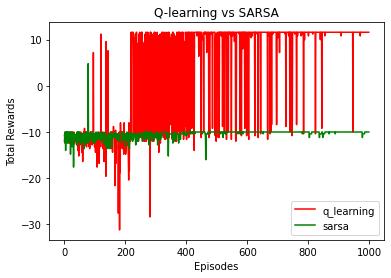

In [125]:
graph_algo(episodes, q_agent_d.rewards, sarsa_agent_d.rewards)

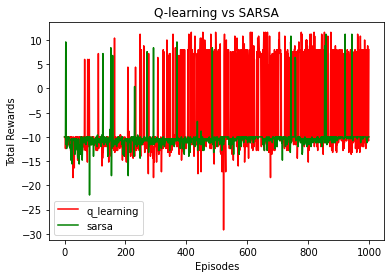

In [126]:
graph_algo(episodes, q_agent_s.rewards, sarsa_agent_s.rewards)

Evaluation

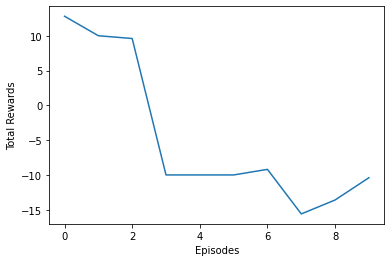

In [127]:
rewards = []
for i in range(10):
  done = False
  total_reward = 0
  state = d_env.reset()
  while not done:
    action = np.argmax(q_agent_d.q_table[state, :])
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
  rewards.append(total_reward)

plt.plot(range(10), rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.show()


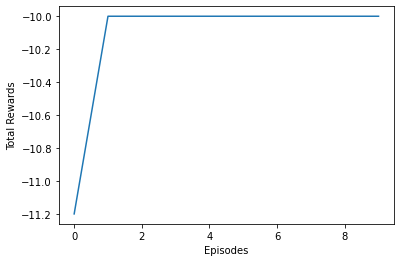

In [128]:
rewards = []
for i in range(10):
  done = False
  total_reward = 0
  state = s_env.reset()
  while not done:
    action = np.argmax(q_agent_s.q_table[state, :])
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
  rewards.append(total_reward)

plt.plot(range(10), rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.show()


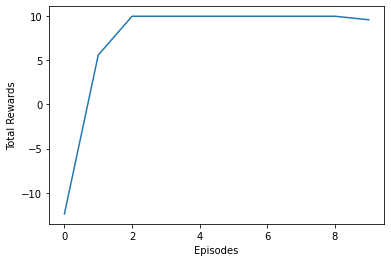

In [129]:
rewards = []
for i in range(10):
  done = False
  total_reward = 0
  state = d_env.reset()
  while not done:
    action = np.argmax(sarsa_agent_d.q_table[state, :])
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
  rewards.append(total_reward)

plt.plot(range(10), rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.show()

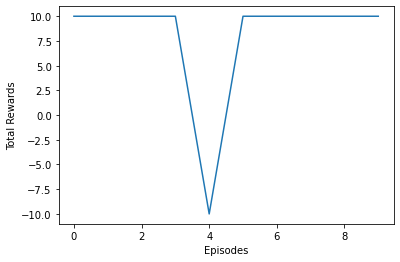

In [130]:
rewards = []
for i in range(10):
  done = False
  total_reward = 0
  state = s_env.reset()
  while not done:
    action = np.argmax(sarsa_agent_s.q_table[state, :])
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state
  rewards.append(total_reward)

plt.plot(range(10), rewards)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards")
plt.show()

Hyperparameter tuning

Stock trading environment

In [138]:
# Defining the Stock Trading Environment.
"""DON'T MAKE ANY CHANGES TO THE ENVIRONMENT."""


class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

                 info: - info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(8, 8))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

In [139]:
# NOTE: You can adjust the parameter 'number_of_days_to_consider'

stock_trading_environment = StockTradingEnvironment('/content/NVDA.csv', number_of_days_to_consider=10)

Q learning for stock trading

In [140]:
class QLearningAgentStock:
  def __init__(self, num_states, num_actions, alpha, gamma, max_epsilon, min_epsilon, decay_rate):
    self.alpha = alpha
    self.gamma = gamma
    self.max_epsilon = max_epsilon
    self.min_epsilon = min_epsilon
    self.decay_rate = decay_rate
    self.q_table = np.zeros((num_states, num_actions))
    self.rewards = []

  def save_model(self, filename): 
    pickle.dump(self.q_table, open(filename, 'wb'))

  def load_model(self, filepath): 
    with open(filepath, 'wb') as f:
      self.q_table= pickle.load(f)

  def train(self, env, episodes):
    decay_rate = pow((self.min_epsilon/ self.max_epsilon), (1/ episodes))
    epsilon = self.max_epsilon
    for episode in range(episodes):
      observation, info = env.reset()
      done = False
      total_reward = 0
      while not done:
      # Choose action using epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
          action = env.action_space.sample()
        else:
          action = np.argmax(self.q_table[observation, :])
        # Take the action and observe the next state and reward
        next_observation, reward, done, truncated, info = env.step(action)

        # Update Q-value
        self.q_table[observation, action] += self.alpha*(reward + self.gamma*np.max(self.q_table[next_observation, :]) - self.q_table[observation, action])
        observation = next_observation
        total_reward += reward

      self.rewards.append(total_reward)
      epsilon /= self.decay_rate

  def eval(self):
      env.train = False
      done = False
      observation, info = env.reset()
      while not done:
        action = np.argmax(self.q_table[observation, :])
        next_observation, reward, done, truncated, info = env.step(action)
        observation = next_observation

In [141]:
stock_alpha=0.15
stock_gamma =0.67
stock_max_epsilon=0.99
stock_min_epsilon=0.4
stock_episodes=100
stock_decay_rate = 0.98

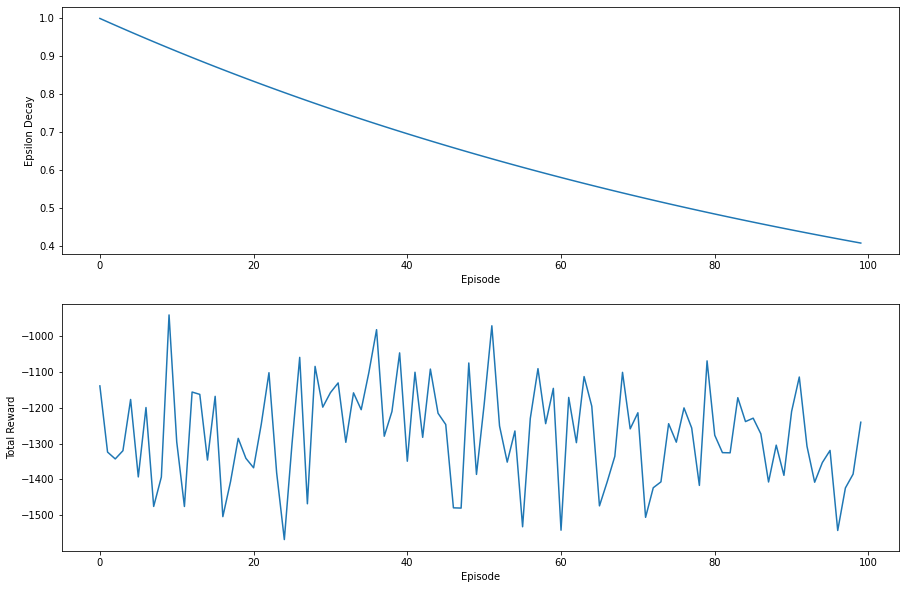

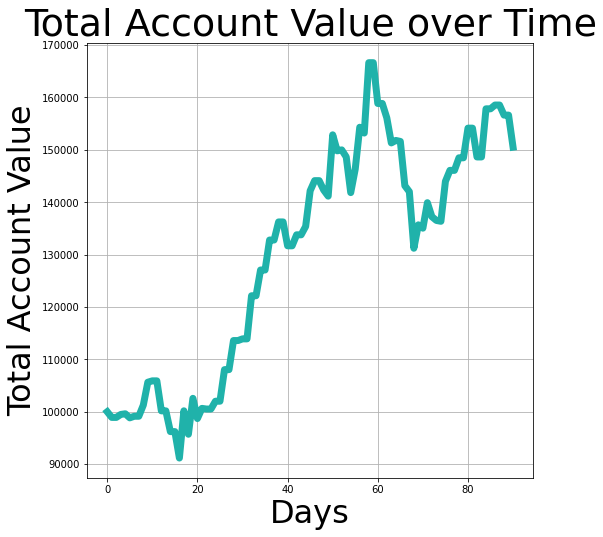

In [142]:
env = StockTradingEnvironment('/content/NVDA.csv')
q_agent_stock = QLearningAgentStock(env.observation_space.n, env.action_space.n, stock_alpha, stock_gamma, stock_max_epsilon, stock_min_epsilon, stock_decay_rate)
q_agent_stock.train(env, stock_episodes)
graph_decay_rewards(stock_episodes, stock_max_epsilon, stock_min_epsilon, q_agent_stock.rewards)
q_agent_stock.eval()
env.render()
q_agent_stock.save_model('stock_qtable1.pkl')

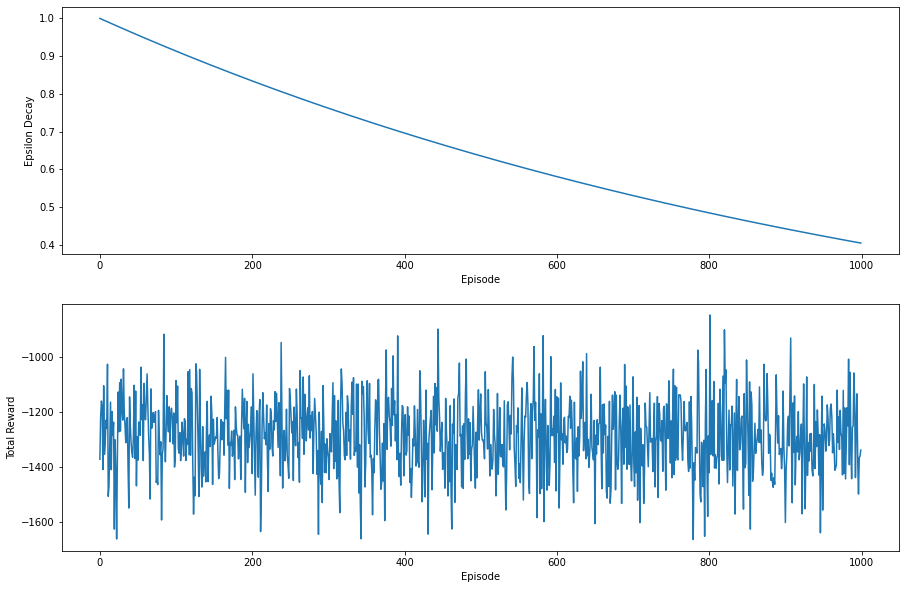

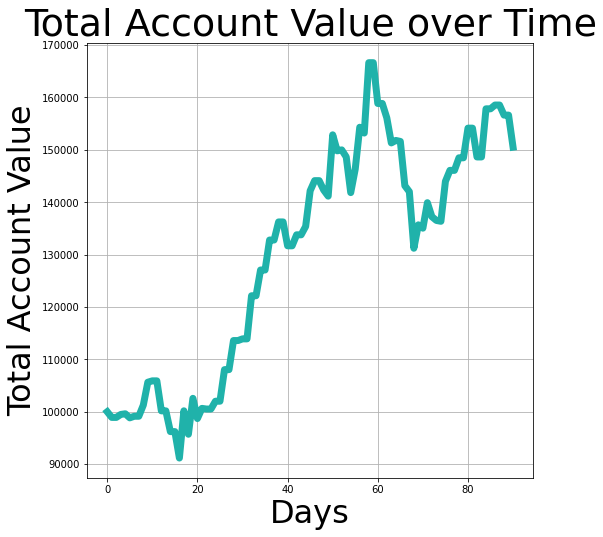

In [143]:
stock_episodes=1000
env = StockTradingEnvironment('/content/NVDA.csv')
q_agent_stock = QLearningAgentStock(env.observation_space.n, env.action_space.n, stock_alpha, stock_gamma, stock_max_epsilon, stock_min_epsilon, stock_decay_rate)
q_agent_stock.train(env, stock_episodes)
graph_decay_rewards(stock_episodes, stock_max_epsilon, stock_min_epsilon, q_agent_stock.rewards)
q_agent_stock.eval()
env.render()
q_agent_stock.save_model('stock_qtable2.pkl')